### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2016 ###

# Image Mosaicking #

#### Ananth Sridhar (ananth.sridhar@wisc.edu), Rangapriya Parthasarathy (prangapriya@gmail.com), Song Mei (smei4@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
  1. [Pixel Absolute Difference](#2.A.-Pixel-absolute-difference)
  1. [Mean Absolute Difference](#2.B.-Mean-absolute-difference)
  1. [Mode Absolute Difference](#2.C.-Mode-absolute-difference)
1. [Solution](#3.-Solution)
  1. [Common Functions](#3.A.-Common-functions)
  1. [Load Images](#3.B.-Load-images)
  1. [Optimization Function](#3.C.-Optimization-function)
  1. [Mosaicking First Image](#3.D.-Mosaicking-first-image)
  1. [More Complicated Image with Image Library](#3.E.-More-complicated-image-with-image-library)
1. [Results and Discussion](#4.-Results-and-discussion)
  1. [Optional Subsection](#4.A.-Feel-free-to-add-subsections)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

Mosaicking is an old art technique where pictures or designs are formed by inlaying small bits of colored stone, glass, or tile. These small bits are visible close up, but the boundaries of the bits will blend and a single recognizable image will show at a distance. 

In the modern digital world, this acient art form has been transformed and combined with new technologies. As one has access to large public image database, individual images, instead of pure-colored blocks can be used as tiles to make pictures. Here is a famous mosaic image of president Obama made by [Anne Savage](http://news.siu.edu/2009/01/011509amh9004.php) during his campaign.
![Obama](http://news.siu.edu/_assets/images/2009/01/asavage_mosaic.jpg)
Nearly 6,000 images of individual faces are used to create this image. Sure enough, it has become a very popular poster because of the special art form. Using image mosaicking to form various pictures is very cool and seems like a daunting task because we are picking and arranging thousands of pictures from a even bigger pool of pictures. There are businesses helping you create your own mosaic work with charge. However, with intuition and just a little knowledge of optimization, we can do it at home ourselves!

We know images consist of pixels, and each pixel can be described using RGB color intensities. In order for two images to look alike, we just need to match their pixels. In this case, for the image to show at a distance, intuitively, we can just treat the basis images as "super pixels" and try to match them with the corresponding subimage of the target image. Naturally, we will take the target image and partition it into a grid whose size is our tile size. Then for each grid, we will choose one image from the basis that resembles the most. The way to qualify "resemblance" is discussed in detail in Part II. Because each chosen basis image resembles the grid best, after processing all grids, we will end up with a mosaicking image that overall best resembles the whole image. Notice that this is the most intuitive way to solve the problem, and it will always achieve the best result. We will present the solution using this method in the first section of Part III. This brute force method is limited by its speed; variants of the algorithm that speeds the process up will be discussed. We will also explore how changing the size of the tiles will affect the performance. The image basis in this project are obtained from online source [mazaika](http://www.mazaika.com/mazdownload.html).

## 2. Mathematical model ##

From the introduction above, it is clear that image mosaicking is an **assignment problem** which can be modeled as a **Mixed Integer Problem**. The **decision variables** $G_i,i\in\mathbf{I}$ ($\mathbf{I}$ is the set of all grids in target image) are which image (represented by its index $j\in\mathbf{B}$, where $\mathbf{B}$ is the set of basis images of size $s$) to choose for each grid $i$ of the target image. Therefore, $\mathbf{B}$ represent the restricted set of values $G_i$ can take. In the mathematical formulation, additional binary variable for each basis image is introduced to indicate whether this image is chosen for the grid. All these variables satisfy the **SOS constraint**. The **objective** is to minimize the difference$^*$ between the chosen mosaic and the target image. Note the difference function should be linear for the model to be MIP. ($^*$ _Several non-linear functions can be used to describe the resemblance of the grid and the basis image and be implemented within special algorithms. But they fall out of the scope of this course and are not discussed here._)

It is worth pointing out that in the current formulation, the optimization of each grid is independent from one another. Therefore, we can lessen the solvers burden by forming a model that solves the sub-problem of optimizing each grid. To optimize the whole target image, one can simply put the model in a function and call it for each grid of the image. For grid size $m\times n$, target grid can be represented by $m\times n\times 3$ RGB matrix $G$. Before optimization, basis images are pre-processed so that they all have the same size as the grid. Each basis image is represented as $m\times n\times 3$ RGB matrix $B_j,j\in\mathbf{B}$. The difference matrix ($m\times n\times 3$) between target $G$ and candidate $B_j$ is $D_j=G-B_j$.

In this project, we have limited the grid sizes to $2^p\times 2^p,~p\in\{0,1,\ldots,6\}$ square grids for the sake of scaling the basis. Further, we make sure the target image can be divided perfectly into integer number of grids. We have explored several differnt cost functions, and the formulation of each is described below.

### 2.A. Pixel absolute difference
$\text{minimize}:\qquad\sum_{x=1}^m\sum_{y=1}^n\sum_{c=R,G,B}~~error_{xy,c}$

$\text{subject to}:\qquad error_{xy,c}\geq E[x,y,c]$

$\qquad\qquad\qquad error_{xy,c}\geq -E[x,y,c]$

$\qquad\qquad\qquad E[x,y,c]=\sum_{j=1}^{s}D_j[x,y,c]\cdot p_j$

$\qquad\qquad\qquad \sum_{j=1}^s p_j=1, p_j\in\{0,1\}$

### 2.B. Mean absolute difference
$\text{minimize}:\qquad\sum_{c=R,G,B}~~error_{c}$

$\text{subject to}:\qquad error_{c}\geq E[c]$

$\qquad\qquad\qquad error_{c}\geq -E[c]$

$\qquad\qquad\qquad E[c]=\sum_{j=1}^{s}D_j[c]\cdot p_j$

$\qquad\qquad\qquad D_j[c]=\frac{1}{mn}\sum_{x=1}^m\sum_{y=1}^nG[x,y,c]-\frac{1}{mn}\sum_{x=1}^m\sum_{y=1}^nB_j[x,y,c],c\in\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1, p_j\in\{0,1\}$

### 2.C. Mode absolute difference
$\text{minimize}:\qquad\sum_{c=R,G,B}~~error_{c}$

$\text{subject to}:\qquad error_{c}\geq E[c]$

$\qquad\qquad\qquad error_{c}\geq -E[c]$

$\qquad\qquad\qquad E[c]=\sum_{j=1}^{s}D_j[c]\cdot p_j$

$\qquad\qquad\qquad D_j[c]=mode(G[:,:,c])-mode(B_j[:,:,c]),c=\{R,G,B\}$

$\qquad\qquad\qquad \sum_{j=1}^{s}p_{j}=1,p_j\in\{0,1\}$

The first formulation is the most straight forward yet most expensive way. The number of varibles and constraints scales with the size of the target image. Further, by trying to match individual pixels, one may not necessarily get the best performance because mosaicking is more about overall resemblance at a distance. As a result, the optimization model using this objective fuction is not shown in the solution part.

Considering matching individual pixels is very expensive and all we care about is the images look close at a distance. It is straight forward to treat each basis image as a whole. We can extract features from the picture. Two most frequently used are the mean (average) of the pixel RGB intensities and the mode (most frequent value) of the pixel RGB. Both of these are implemented.

## 3. Solution ##
### 3.A. Common functions
The following module contains all the helper functions to process the images. Run this section first before moving on to the optimization model.

In [2]:
using Images, DataFrames, FixedPointNumbers, PyPlot, Colors, ProgressMeter

# loads all jpg image files inside the directory
function get_image_files(image_dir)
    # get all the files in the directory
    dir_contents = readdir(image_dir)
    dir_contents = [ join([image_dir, dir_contents[i]], "/") for i in 1:length(dir_contents) ]
    
    # retain only jpg image files
    image_files = filter(x->ismatch(r"(.jpg$)|(.jpeg$)"i, x), dir_contents)
    
    # return the paths to the jpg image files
    return image_files
end

# converts image to a h x w matrix
#   h = height
#   w = width
function convert_image_to_mat(image)
    image_mat = reinterpret(UInt8, separate(image).data)
    return image_mat
end

# converts a h x w matrix to an Images module image
function convert_mat_to_image(image_mat)
    image = colorim(image_mat)
    return image
end

# load a list of image files as a cell array of image matrices
function load_images_as_cellarray_mats(image_files)
    images_mat = cell(length(image_files),1)
    for (image_n, image_file) in enumerate(image_files)
        image = load(image_file)
        image_mat = convert_image_to_mat(image)
        
        # fix for RGB4 seen on Mac because of ImageMagick behavior
        #  read only RGB (ignore the 4th value)
        image_mat = image_mat[:,:,1:3]
        
        images_mat[image_n] = image_mat
    end
    return images_mat
end

# convert a cell array of image matrices to a cell array of images
function load_cellarray_mats_as_images(images_mat)
    images = cell(length(images_mat),1)
    for (image_n, image_mat) in enumerate(images_mat)
        image = convert_mat_to_image(image_mat)
        images[image_n] = image
    end
    return images
end

# silly way to make all images the same size
function subsample_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
        images_mat[image_n] = image[1:desired_size[2], 1:desired_size[1], :]
    end
    return images_mat
end

# scale an image (fixed size 64x64) to the desired size
function scale_image(image,desired_size)
    n_combine = 64/desired_size[1]
    n_pixel = n_combine*n_combine
    temp=image[1:desired_size[2], 1:desired_size[1], :]
    for i in 1:desired_size[2]
        for j in 1:desired_size[1]
            sub = image[(i-1)*n_combine+(1:n_combine),(j-1)*n_combine+(1:n_combine),:]
            for c in 1:3
                pixel=convert(UInt8,round(sum(sum(sub[:,:,c]))/n_pixel))
                temp[i,j,c]=pixel
            end
        end
    end
    return temp
end

# scale a list of images to the desired size
function scale_cellarray_mats(images_mat, desired_size)
    for (image_n, image) in enumerate(images_mat)
            images_mat[image_n] = scale_image(image,desired_size)
    end
    return images_mat
end

; # suppress output

### 3.B. Load images
This section contains the sample preparation work before mosaicking image. Loading the test images, loading the basis images, and scaling the basis images to the desired size. These will be copied and properly modified in following sections when we do different mosaickings.

In [4]:
# load target images
test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)

println(length(test_images_mat), " test image files loaded")

test_image = test_images_mat[1]

#**************************************
# library with 4 gray scale images
#**************************************
image_files = get_image_files("./grayscale") 

#**************************************
# library with images
#**************************************
# image_files = get_image_files("./music0500")
# image_files = get_image_files("./music1000")
# image_files = get_image_files("./music1500")

# load basis images
images_mat = load_images_as_cellarray_mats(image_files)
# set desired size and rescale the basis images
base_size = 16
# scale the basis images to desired size
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

# get dimensions 
n_basis = length(images_mat) # number of basis images
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

; # to suppress display

1 test image files loaded
4 basis image files loaded


### 3.C. Optimization function
The optimization of a single grid put in a function.

In [5]:
using JuMP, Mosek
function pickOpt(sub_test_image,optimize_color)
    m = Model(solver = MosekSolver(LOG=1))
    @defVar(m, pick_basis[1:n_basis], Bin)
    @defVar(m, AbsMatchError[1:n_colors] >= 0)
        
    @addConstraint(m, sum(pick_basis) == 1)
        
    test_image_value = nothing
    if optimize_color
        test_image_value = [ mode(sub_test_image[:,:,color]) for color in 1:n_colors ]
    else
        test_image_value = [ mean(sub_test_image[:,:,color]) for color in 1:n_colors ]
    end
        
    @defExpr(m, MatchError[color in 1:n_colors], test_image_value[color] - sum(dot(pick_basis,basis_colors[:,color])) )
    @addConstraint(m, MatchError .<=  AbsMatchError)
    @addConstraint(m, MatchError .>= -AbsMatchError)
        
    @setObjective(m, Min, sum(AbsMatchError))
        
    status = solve(m)
    # show some output to communicate that things are moving forward
    opt_pick_basis = getValue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end;

### 3.D. Mosaicking first image
Try mosaicking our first image. Target is a black and white QR code image, and we choose the gray scale image set. Should be able to get the exact picture back with small enough basis images.

4 basis image files loaded
Progress: 100% Time: 0:00:21


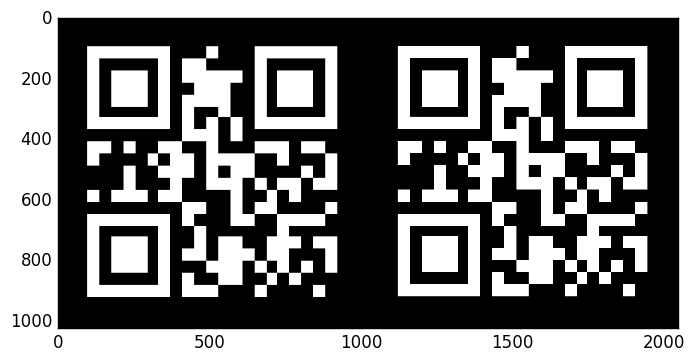

In [14]:
# load target images
test_image = test_images_mat[1]

# use gray scale
image_files = get_image_files("./grayscale") 

# load basis images
images_mat = load_images_as_cellarray_mats(image_files)
# set desired size and rescale the basis images
base_size = 8
# scale the basis images to desired size
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

# get dimensions 
n_basis = length(images_mat) # number of basis images
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

optimize_color = true
basis_colors = nothing
n_colors = nothing
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = similar(test_image)

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick out the target grid
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        if optimize_color
            n_colors = 3
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
                end
            end
        else
            n_colors = 1
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
                end
            end
        end
        chosen_basis = pickOpt(sub_test_image,optimize_color)
        basis_choice[j,i] = chosen_basis
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
    end
end

# plot two images side by side to see how we did
imshow([test_image mosaic_image]);

### 3.E. More complicated image with image library
Try mosaicking our first image. Target is a black and white QR code image, and we choose the gray scale image set. Should be able to get the exact picture back with small enough basis images.

3 test image files loaded


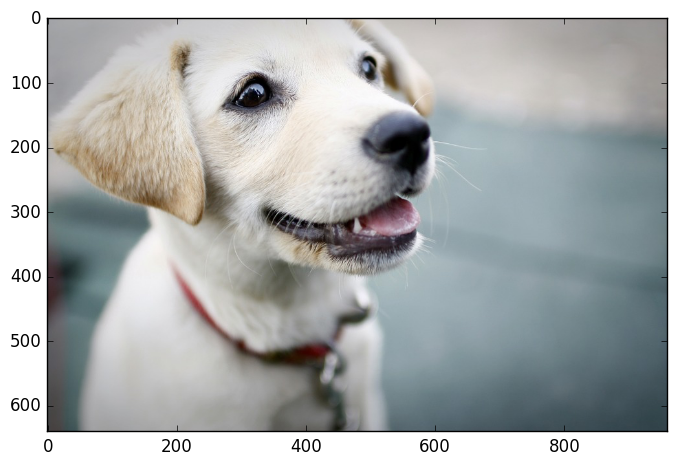

PyObject <matplotlib.image.AxesImage object at 0x31eb2b128>

In [16]:
test_image_files = get_image_files("./test_images")
test_images_mat = load_images_as_cellarray_mats(test_image_files)

println(length(test_images_mat), " test image files loaded")
imshow(test_images_mat[2])

498 basis image files loaded
Progress: 100% Time: 0:27:07


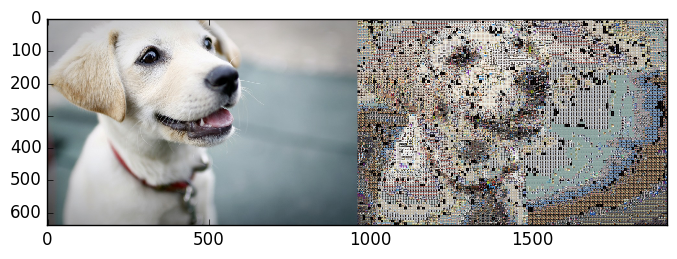

In [17]:
test_image = test_images_mat[2]

image_files = get_image_files("./music0500")
# load basis images
images_mat = load_images_as_cellarray_mats(image_files)
# set desired size and rescale the basis images
base_size = 8
# scale the basis images to desired size
desired_size = (base_size, base_size)
images_mat = scale_cellarray_mats(images_mat, desired_size)

println(length(images_mat), " basis image files loaded")

# get dimensions 
n_basis = length(images_mat) # number of basis images
w_basis = size(images_mat[1], 2) # basis width
h_basis = size(images_mat[1], 1) # basis height
w_test_image = size(test_image, 2) # target width
h_test_image = size(test_image, 1) # target height

n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

optimize_color = true
basis_colors = nothing
n_colors = nothing
basis_choice = zeros(n_basis_height, n_basis_width)
mosaic_image = similar(test_image)

@showprogress 1 for j = 1:n_basis_height
    for i = 1:n_basis_width
        # pick out the target grid
        sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
        if optimize_color
            n_colors = 3
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
                end
            end
        else
            n_colors = 1
            basis_colors = zeros(n_basis, n_colors)
            for color in 1:n_colors
                for basis in 1:n_basis
                    basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
                end
            end
        end
        chosen_basis = pickOpt(sub_test_image,optimize_color)
        basis_choice[j,i] = chosen_basis
        mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
    end
end

# plot two images side by side to see how we did
imshow([test_image mosaic_image]);

## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.

Use plots (see `PyPlot` and `Gadfly` examples from class), or you can display results in a table like this:

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned |\$1600 |
| col 2 is      | centered      |  \$12 |
| zebra stripes | are neat      |   \$1 |

### 4.A. Feel free to add subsections

#### 4.A.a. or subsubsections

## 5. Conclusion ##

Summarize your findings and your results, and talk about at least one possible future direction; something that might be interesting to pursue as a follow-up to your project.